# **Sign languages Classification**

**Authors:**

* FOZAME ENDEZOUMOU Armand Bryan
* Jessica MBOUNKAP
* Maheni SOUMAH
* LEUMALEU MBOUYOM Arnold Vianey
* William TOWA Darryl KENGNE
* Habiba  DJIGO




## Business Understanding

This is a dataset of images containing American Sign Language (ASL). Each directory has more than 80 photos. Images were taken from students at UTEC (University of Engineering and Technology, Peru). This dataset was developed to implement a sign language translator. The project was based on digital image processing techniques and implemented in MATLAB. The results of this project are shown in Demo1 and Demo2 videos.

This project was done by Cristian Amaya and Victor Murray.
Contact email: cristian.amaya@utec.edu.pe and vmurray@ieee.org

Version: 2020.08.31.1

Using the database

This database can be used, free of charge, only for research and educational purposes. Copy, redistribution, and any unauthorized commercial use are prohibited. Any researcher using this database must reference it by adding the following information (https://doi.org/10.1109/INTERCON50315.2020.9220241):

## Data Comprehension

In [ ]:
#Mount the disk
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#librairies

import os
import time
from tqdm import tqdm
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

Here's a brief description of the libraries used:

1. **`os`**: This library provides an interface for interacting with the operating system, allowing manipulation of file paths, creating directories, listing files, etc.

2. **`tqdm`**: A library used to display progress bars during loops or long-running operations. It's helpful for tracking the progress of tasks.

3. **`torch`**: The core library for tensor computation in PyTorch. It provides data structures like tensors and operations on those tensors.

4. **`torch.nn`**: Part of PyTorch, it contains modules for building neural networks, loss functions, optimizers, etc.

5. **`torch.optim`**: A PyTorch module that provides various optimizers (Adam, SGD, etc.) used to adjust model weights during training.

6. **`torch.utils.data`**: A PyTorch module containing utilities for handling datasets and loading data during training.

7. **`datasets`**: A PyTorch module containing predefined datasets and commonly used transformations.

8. **`transforms`**: A PyTorch module for commonly used image transformations, such as resizing, normalization, etc.

9. **`cv2` (OpenCV)**: A popular library for computer vision. It provides tools for image processing, computer vision, and related tasks.

10. **`matplotlib.pyplot`**: Used to create plots and visualizations in Python.

In [ ]:
print('Version of pytorch: {}'.format(torch.__version__))

Version of pytorch: 2.1.0+cu121


Here we have to deal with images, and in our case we don't have a well-made .csv file for us with the different paths. Therefore we will have to look for the paths ourselves and find a method to correctly manipulate these paths.

It is also essential to visualize the images, where they are contained...

In [ ]:
PATH = '/content/drive/MyDrive/Machine Learning project Aivancity/Datasets/classification images/sign classification/ASL_Dataset-master'
print(os.listdir(PATH)) #print all files in the folder
list_dir = os.listdir(PATH)

['B', 'H', 'X', 'M', 'W', 'Q', 'F', 'C', 'E', 'K', 'A', 'I', 'Y', 'L', 'P', 'O', 'G', 'U', 'R', 'D', 'N', 'S', 'V', 'T']


In [ ]:
labels = list_dir # we will it for labels (y)
labels = sorted(labels)# Organize the list to start with 'A'
print(labels)

del list_dir # erase variable

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


We created and used a split_dataset function via a script to be able to create a train and test folder in each folder and move 80% of the images into the train and 20% into the test.

The split_dataset function has been added in our <a href='https://github.com/Bryan-Foxy/ml-project/blob/image-classification/split_dataset_py.py'>github</a>

In [ ]:
def delete_non_image_files(directory):
    """
    Delete all files that are not in jpg, jpeg, or png format in the specified directory.

    Parameters:
    - directory (str): The path to the directory.

    Returns:
    None
    """
    # Verify the existence of the directory
    if not os.path.exists(directory):
      print(f"The directory {directory} does not exist.")
      return

    # store list of file in the directory
    file_list = os.listdir(directory)

    # Searching the file list
    for file_name in file_list:
      file_path = os.path.join(directory, file_name)

      if os.path.isfile(file_path):
        # Verification
        if not file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
          # Delete the file
          os.remove(file_path)
          print(f"Deleted: {file_path}")


def count_file(directory, labels, train = True):
    """
    Counts the number of files in each subdirectory of the given directory.

    Parameters:
    - directory (str): The main directory containing subdirectories for each label.
    - labels (list): List of labels corresponding to the subdirectories.

    Returns:
    list: A list containing the number of files in each subdirectory.

    This function helps visualize the distribution of images across different folders.
    It is useful for checking if the images are balanced across labels or not.
    The function iterates through each label's subdirectory, counts the number of files,
    and returns a list containing these counts.
    """
    file_counts = []
    for i in range(len(labels)):
        dir_path = os.path.join(directory, labels[i])
        file = os.listdir(dir_path)
        delete_non_image_files(dir_path)
        idx = 0

        #check train index
        if train == True:
          if file[0] == 'train':
            idx = 0
          elif file[1] == 'train':
            idx = 1
        else:
          if file[0] == 'test':
            idx = 0
          elif file[1] == 'test':
            idx = 1

        dir_path = os.path.join(dir_path,file[idx])
        len_dir_path = len(os.listdir(dir_path))
        file_counts.append(len_dir_path)

    return file_counts

In [ ]:
bar_len_y = count_file(PATH, labels)
for i in range(len(bar_len_y)):
  print('Number images of in the train set {} = {} images'.format(labels[i], bar_len_y[i]))

Number images of in the train set A = 68 images
Number images of in the train set B = 76 images
Number images of in the train set C = 74 images
Number images of in the train set D = 72 images
Number images of in the train set E = 76 images
Number images of in the train set F = 82 images
Number images of in the train set G = 82 images
Number images of in the train set H = 71 images
Number images of in the train set I = 75 images
Number images of in the train set K = 80 images
Number images of in the train set L = 82 images
Number images of in the train set M = 79 images
Number images of in the train set N = 77 images
Number images of in the train set O = 77 images
Number images of in the train set P = 80 images
Number images of in the train set Q = 79 images
Number images of in the train set R = 80 images
Number images of in the train set S = 82 images
Number images of in the train set T = 82 images
Number images of in the train set U = 79 images
Number images of in the train set V = 71

In [ ]:
bar_len_y_test = count_file(PATH, labels, train = False)
for i in range(len(bar_len_y_test)):
  print('Number images of in the test set {} = {} images'.format(labels[i], bar_len_y_test[i]))

Number images of in the test set A = 15 images
Number images of in the test set B = 17 images
Number images of in the test set C = 16 images
Number images of in the test set D = 16 images
Number images of in the test set E = 17 images
Number images of in the test set F = 18 images
Number images of in the test set G = 18 images
Number images of in the test set H = 15 images
Number images of in the test set I = 17 images
Number images of in the test set K = 17 images
Number images of in the test set L = 18 images
Number images of in the test set M = 17 images
Number images of in the test set N = 16 images
Number images of in the test set O = 17 images
Number images of in the test set P = 17 images
Number images of in the test set Q = 18 images
Number images of in the test set R = 17 images
Number images of in the test set S = 17 images
Number images of in the test set T = 18 images
Number images of in the test set U = 18 images
Number images of in the test set V = 16 images
Number images

We have to be honest, we don't have a lot of images to train and test. This observation sheds light on the choice of the method to use for the model.

Text(0.5, 0, 'Label of each images')

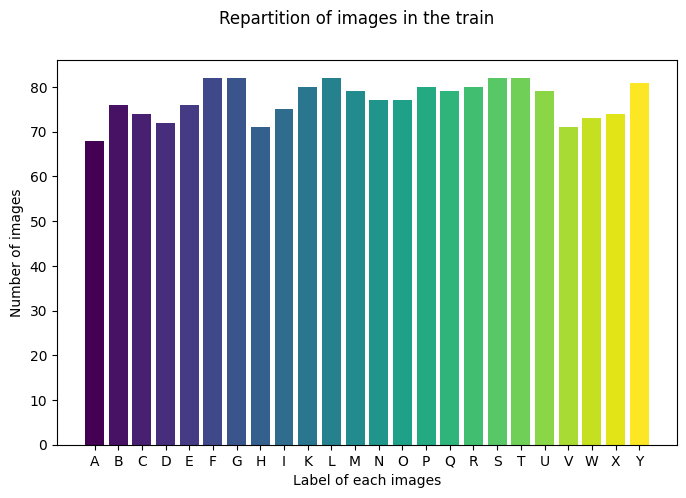

In [ ]:
# Setup figure
fig, ax = plt.subplots(figsize=(8,5))
# Different colors for each label
colors = plt.cm.viridis(torch.linspace(0, 1, len(labels)))

# Figure
fig.suptitle('Repartition of images in the train')
ax.bar(labels, bar_len_y, color = colors)
ax.set_ylabel('Number of images')
ax.set_xlabel('Label of each images')

We can see that the data is not perfectly balanced but that's okay because there is not too big a difference.
We can conclude that the data set is more or less balanced.

Note that the letter A and H have fewer samples than all the rest.

Let's visualize our images.

Text(0.5, 0, 'Label of each images')

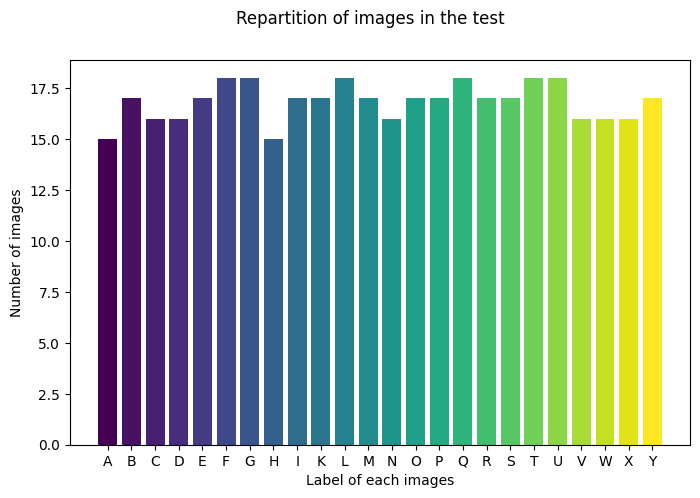

In [ ]:
# Setup figure
fig, ax = plt.subplots(figsize=(8,5))
# Different colors for each label
colors = plt.cm.viridis(torch.linspace(0, 1, len(labels)))

# Figure
fig.suptitle('Repartition of images in the test')
ax.bar(labels, bar_len_y_test, color = colors)
ax.set_ylabel('Number of images')
ax.set_xlabel('Label of each images')

In [ ]:
def plot_image(directory, alphabet, idx = 0):
    """
    Plots one image from each folder in the provided directory.

    Parameters:
    - directory (str): The main directory containing subdirectories for each label.
    - alphabet (list): List of labels corresponding to the subdirectories.
    - idx (int): idx equal to 0 is for train and idx equal to 1 is for test

    Returns:
    None

    This function creates a grid of images, with each row representing a label from the alphabet.
    It displays one image from each label's subdirectory. The grid has 6 rows and 4 columns, making it
    suitable for a total of 24 labels. The images are read using OpenCV, converted to RGB, and then
    displayed in the corresponding grid cell with the label as the title.
    """
    # Setup
    # We choose 6 rows and 4 cols because the number of labels is 24
    fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12, 10))
    fig.suptitle("Sign Language", fontsize=20)

    for i in range(len(alphabet)):
        dir_path = os.path.join(directory, alphabet[i])
        dir_files = os.listdir(dir_path)
        dir_path_img = os.path.join(dir_path, dir_files[idx])
        dir_files = os.listdir(dir_path_img)
        dir_path_img = os.path.join(dir_path_img, dir_files[0])
        img = cv2.imread(dir_path_img)
        img_cv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Figure
        ax[i // 4, i % 4].axis('off')
        ax[i // 4, i % 4].imshow(img_cv)
        ax[i // 4, i % 4].set_title(alphabet[i], color ='green')

    fig.tight_layout()


def find_idx(lst, value):
    """
    Finds the index of a specified value in a given list.

    Parameters:
    - lst (list): The list to search for the specified value.
    - value (any): The value to find in the list.

    Returns:
    int or None: The index of the first occurrence of the value in the list,
                or None if the value is not present in the list.

    This function searches for the specified value in the given list and returns its index.
    If the value is not found, it returns None.
    """
    try:
        idx = lst.index(value)
        return idx
    except ValueError:
        return None


def plot_img_label(directory, alphabet, label='A', num_images=10):
    """
    Plots a specified number of images from a chosen label in the given directory.

    Parameters:
    - directory (str): The main directory containing subdirectories for each label.
    - alphabet (list): List of labels corresponding to the subdirectories.
    - label (str): The chosen label for which images will be plotted (default is 'A').
    - num_images (int): The number of images to plot (default is 10).

    Returns:
    None

    This function plots a grid of images from the specified label within the provided directory.
    The grid has 2 rows and 5 columns, and it displays up to 'num_images' images.
    """
    idx = find_idx(alphabet, label)
    if idx is not None:
      img_path = os.path.join(directory, alphabet[idx])
      fig, ax = plt.subplots(2, 5)
      fig.suptitle('Images for Label {}'.format(label))
      for i in range(num_images):
        file_dir = os.listdir(img_path)[0]
        file_dir_img = os.path.join(img_path, file_dir)
        file_dir = os.listdir(img_path)[0]
        file_dir_img = os.path.join(img_path, file_dir)
        dir_img = os.listdir(file_dir_img)[i]
        file_img = os.path.join(file_dir_img, dir_img)
        img = cv2.imread(file_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax[i // 5, i % 5].axis('off')
        ax[i // 5, i % 5].imshow(img)
    else:
        print('Label "{}" not found in the provided alphabet.'.format(label))


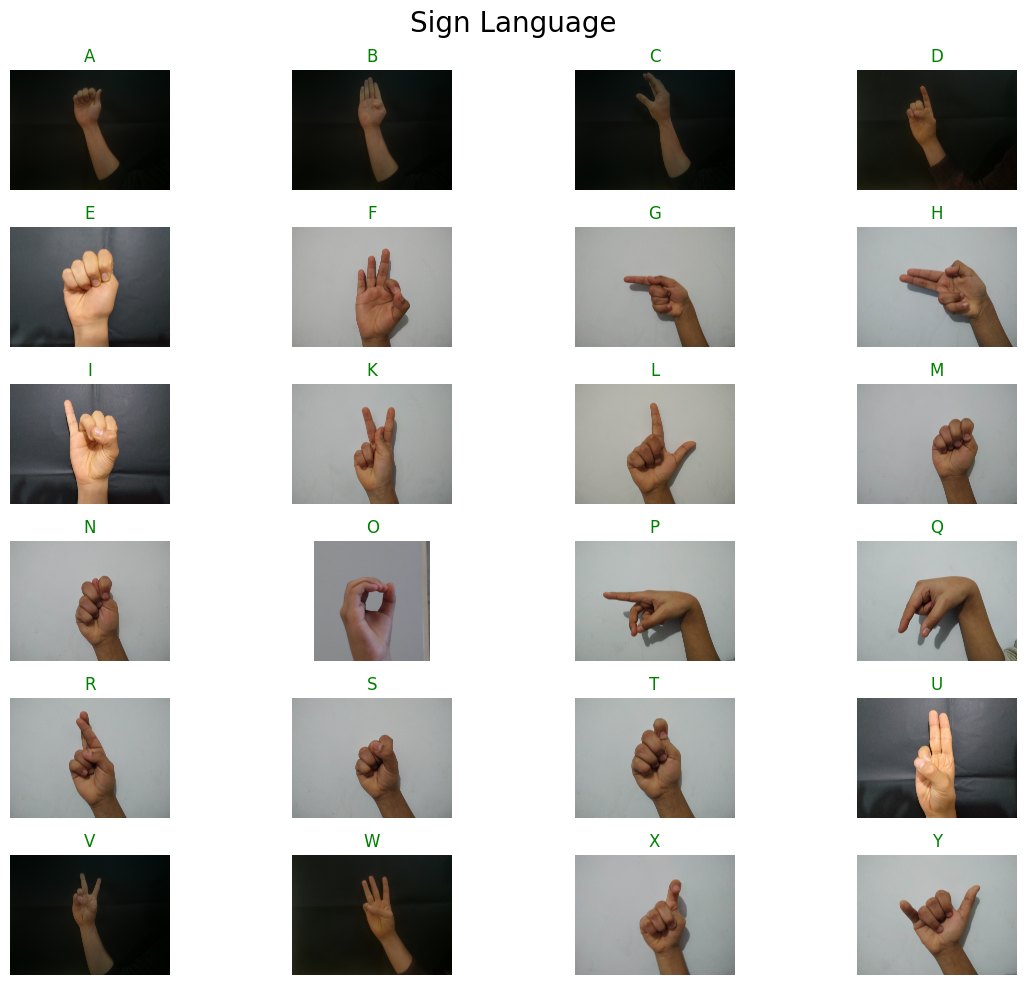

In [ ]:
plot_image(PATH, labels)

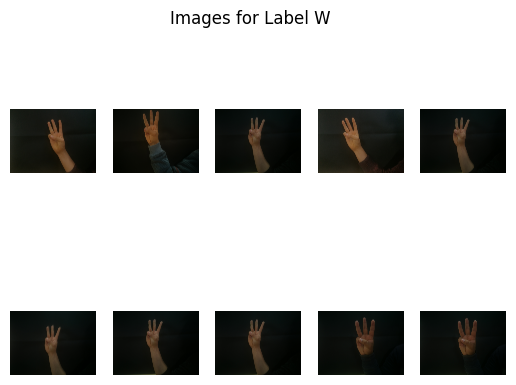

In [ ]:
plot_img_label(PATH, labels, 'W')

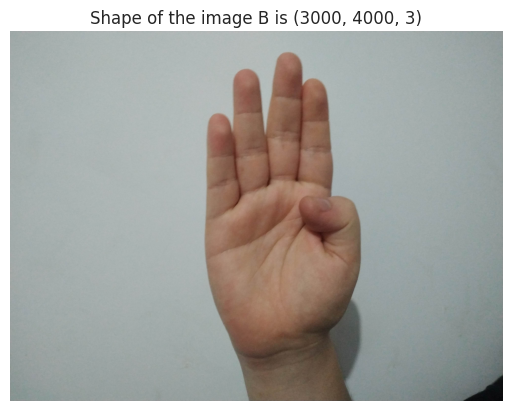

In [ ]:
#print the dimension of a random image
id_label = torch.randint(len(labels), size=(1,)).item()
img_file = os.path.join(PATH, labels[id_label]) #We choose random
id_val = torch.randint(len(img_file), size=(1,)).item()
img_path = os.listdir(img_file)[0]
img_ = os.path.join(img_file, img_path)
idx = os.listdir(img_)[id_val]
img_ = os.path.join(img_, idx)
img = cv2.imread(img_)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_shape = img.shape
plt.title('Shape of the image {} is {}'.format(labels[id_label], img_shape))
plt.axis('off')
plt.imshow(img)

After several attempts, we have observed that all the images have a size of (3000, 4000, 3). We need to reduce the size of these images to decrease the computation time.


**Bonus**

Let's not forget that images are tensors, and in this case, we have a 3D image tensor ($n = 3$) with an RGB (Red - Green - Blue) format, so 3 channels. Therefore, we can decompose our image to visualize each of the channels.

In [ ]:
def decomposition_image(image):
  """
  Plot the every single channel of the image

  Args:
  - image (numpy.darray) : Original image we want to decompose

  Returns:
  None

  """
  n = image.shape[2]
  fig, axs = plt.subplots(1,n, figsize=(9,3))
  rgb_list = []

  # Decompose the RGB image
  for i in range(n):
    wrap = image.copy()
    if i == 0:
      wrap[:,:,1] = 0
      wrap[:,:2] = 0
      rgb_list.append(wrap)
    elif i == 1:
      wrap[:,:,0] = 0
      wrap[:,:,2] = 0
      rgb_list.append(wrap)
    elif i == 2:
      wrap[:,:,0] = 0
      wrap[:,:,1] = 0
      rgb_list.append(wrap)

  rgb_c = ['red channel', 'green channel', 'blue channel']

  for i in range(n):
    axs[i].imshow(rgb_list[i])
    axs[i].axis('off')
    axs[i].set_title(rgb_c[i])

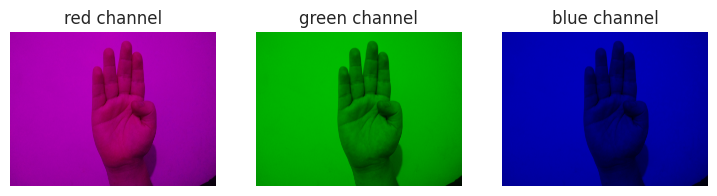

In [ ]:
decomposition_image(img)

We will create a CustomDataset for this data and then put them into a DataLoader.

By resizing the images, we aim to make the analysis more efficient and computationally feasible.

## Data Preparation

In [ ]:
def list_to_dict(lst):
    """
    Converts a list into a dictionary assigning values from 0 to n to each element.

    Args:
        lst (list): The list of elements to convert.

    Returns:
        dict: A dictionary where each element of the list is a key, and its value is assigned from 0 to n.
    """
    return {element: index for index, element in enumerate(lst)}

dict_labels = list_to_dict(labels)
print(dict_labels)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [ ]:
def normalize(tensor):
  """
  Apply MinMaxScaler normalization

  Args:
  - tensor (torch.Tensor): It's the tensor who need to be normalize

  Returns:
  torch.Tensor: The tensor normalize
  """

  min_val = torch.min(tensor)
  max_val = torch.max(tensor)

  norm_tensor = (tensor - min_val) / (max_val - min_val)

  return norm_tensor

def find_key_by_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    # If the value is not found, return None or a default value
    return None

Let's check the output of an image normalized to scale 0 - 1

(-0.5, 3999.5, 2999.5, -0.5)

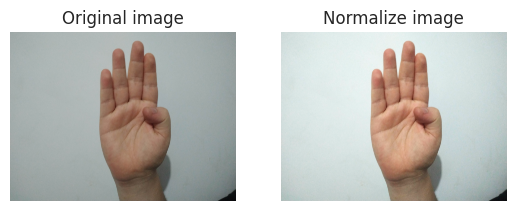

In [ ]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
img_norm = normalize(torch.tensor(img))
plt.title('Normalize image')
plt.imshow(img_norm)
plt.axis('off')

You might be wondering why the normalized image appears brighter than the original image. Let us clarify.

In image processing, contrast is an intrinsic characteristic of an image that measures the difference in brightness between its light and dark areas. It contributes to enhancing the image's clarity and definition.

During this process, we adjust the intensity of each pixel in the image to achieve a histogram that is evenly distributed along the X-axis. Normalization ensures that the resulting matrix has its smallest value at 0 and its largest value at 1. With this scaling change, the intensities are within a smaller range, thus better distributed along the X-axis compared to the original image.

For example, consider Lena:

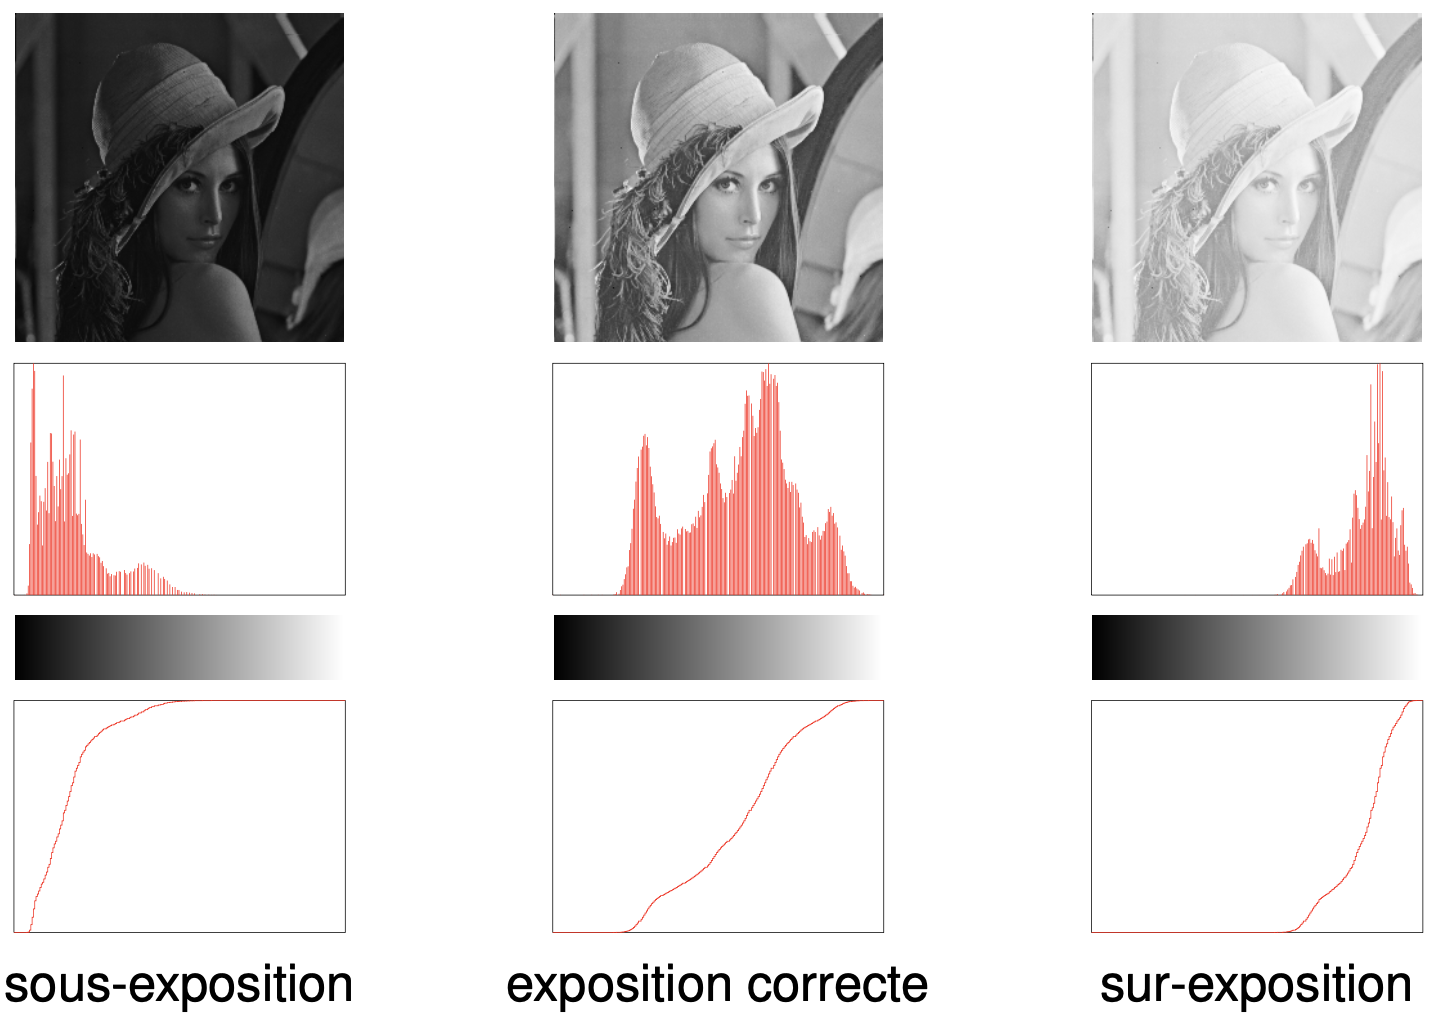

To create a compelling model capable of generalizing across various training scenarios, we need to apply transformations to our training dataset. We can accomplish this using the `torchvision.transforms` library, which enables us to perform operations such as rotation, brightness adjustments, and more on the images. These transformations aid the model in achieving better generalization by exposing it to a diverse range of training examples.

In [ ]:
# Apply some transformations for our images
transform = transforms.Compose([
    transforms.RandomRotation(degrees=[-90,90]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0)
    ])

Transformations apply:

1. **RandomRotation**: Rotates the image by a random angle chosen uniformly from the range (-20, 20) degrees. This helps the model become more robust to variations in orientation.
2. **RandomHorizontalFlip**: Flips the image horizontally with a probability of 0.5. This introduces additional variation by presenting mirror images to the model during training.
3. **ColorJitter**: Randomly adjusts the brightness and contrast of the image. In this case, brightness and contrast are adjusted within a range of ±0.2. This augmentation technique helps the model generalize better to different lighting conditions.
4. **RandomResizedCrop**: Randomly crops and resizes the image to the specified size (224x224 pixels) with a random scale factor chosen from the range (0.8, 1.0). This augmentation technique helps the model learn from different scales and perspectives of the input images.


In [ ]:
class CustomDataset(Dataset):
    """
    Abstract class representing the dataset.

    Parameters:
    - Dataset(torch.utils.data.Dataset): Inheritance from PyTorch Dataset class.

    Returns:
    None

    The main task of the Dataset class is to return a pair of [input, label] every time it is called.
    We can define functions inside the class to preprocess the data and return it in the format we require.
    """

    def __init__(self, root_dir, dict_labels, mode='train', normalize = True, isplit = True, transform = None):
        """
        Initializes the CustomDataset.

        Args:
        - root_dir (str): The root directory containing subdirectories for each label.
        - dict_labels (dict): A dictionary mapping label names to class IDs.
        - mode (str): 'train' or 'test' to specify the dataset split. Default is 'train'.

        Returns:
        None
        """
        self.root_dir = root_dir
        self.data = []
        self.labels = dict_labels
        self.img_dim = (299, 299)
        self.mode = mode
        self.normalize = normalize
        self.idx = 0
        self.isplit = isplit
        self.transform = transform

        # Select the appropriate directory based on the mode
        data_dir = 'train' if mode == 'train' else 'test'
        file_dir = os.listdir(self.root_dir)

        for i in range(len(file_dir)):
            label = file_dir[i]
            img_dir = os.path.join(self.root_dir, label)

            if self.isplit == True:
              dir = os.listdir(img_dir)
              #check data_dir
              if dir[0] == data_dir:
                self.idx = 0
              elif dir[1] == data_dir:
                self.idx = 1

              img_path = os.path.join(img_dir, dir[self.idx])
              img_list = os.listdir(img_path)

              for j in range(len(img_list)):
                path = os.path.join(img_path, img_list[j])
                self.data.append([path, label])

            else:
              img_path = os.listdir(img_dir)
              img_path = str(img_path[0])
              path = os.path.join(img_dir, img_path)
              self.data.append([path, label])



    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        int: The length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a specific sample from the dataset.

        Args:
        - idx (int): Index of the sample.

        Returns:
        torch.Tensor: The image tensor.
        torch.Tensor: The class ID tensor.
        """
        img_path, label = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.labels[label]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.to(torch.float32)

        # Normalization
        if self.normalize == True:
          # Put scaler between 0 and 1
          img_tensor = normalize(img_tensor)

        # Channels first
        img_tensor = img_tensor.permute(2, 0, 1)

        # Apply transformations if they are provided
        if self.transform:
          img_tensor = self.transform(img_tensor)


        return img_tensor, class_id


In [ ]:
train_dataset = CustomDataset(PATH, dict_labels, 'train', transform = transform)
test_dataset = CustomDataset(PATH, dict_labels, 'test')

In [ ]:
batch_size = 32

In [ ]:
# Build dataloader
train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                              shuffle = True, pin_memory = True, num_workers = 20)

test_dataloader = DataLoader(test_dataset, batch_size = batch_size,
                             shuffle = False, pin_memory = True, num_workers = 20)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


A `DataLoader` in PyTorch is a utility that provides an efficient way to load and iterate over a dataset during the training or evaluation of a machine learning model. It helps in managing various aspects of data loading, such as shuffling, batching, and parallel loading, to enhance training efficiency. Let's break down the parameters of the `DataLoader` you've mentioned:

1. `train_dataset`: This is the dataset that the `DataLoader` will iterate over. It should be an instance of a PyTorch dataset class.

2. `batch_size`: It defines the number of samples in each batch that the `DataLoader` will provide during each iteration. Batching is a common practice in deep learning to leverage parallelism and optimize memory usage.

3. `shuffle`: When set to `True`, this parameter randomizes the order of data samples in each epoch, which is crucial during the training phase to ensure the model doesn't learn sequence patterns. Shuffling is recommended for the training set but not for the validation or test set.

4. `pin_memory`: If set to `True`, it enables the DataLoader to use pinned memory, which can speed up data transfer between CPU and GPU. It's beneficial when working with GPU acceleration.

5. `num_workers`: This parameter specifies the number of worker processes to use for data loading. It allows parallel loading of data, making it faster by utilizing multiple CPU cores. However, too many workers may lead to resource contention, so the optimal value depends on the system configuration.


In [ ]:
def display_dataloader(dataloader):
  """
  Display 5 images of the dataloader

  Args:
  - dataloader (torch.data.utils.DataLoader): The data store into several batches for a better computation power

  Returns:
  None
  """
  imgs, labels = next(iter(dataloader))
  del labels
  #figure
  fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(8,5))
  for i in range(5):
    idx = torch.randint(low = 0, high = (len(imgs) - 1), size = (1,))
    img = imgs[idx].squeeze()
    img = img.permute(1,2,0)

    ax[i].imshow(img)
    ax[i].axis('off')


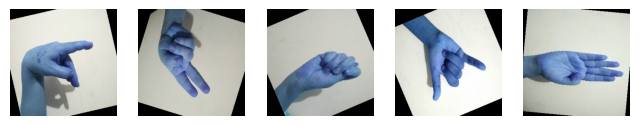

In [ ]:
display_dataloader(train_dataloader)

## Modeling

We've now reached the modeling phase. Initially, we're dealing with a multiclass classification task, and the challenge lies in the limited number of available images.

In this scenario, there's no need for alarm; instead, we'll leverage the power of a pre-trained model.

A pre-trained model is a robust neural network that has been extensively trained on vast datasets, encompassing a wide array of problems. It has acquired intricate and nuanced features from diverse data.

Employing a pre-trained model allows us to harness the knowledge encoded within and fine-tune it for our specific task, even when confronted with a relatively small dataset.

Among the plethora of pre-trained models, we'll focus on Inception for its noteworthy capability to deliver impressive results while maintaining a relatively compact parameter count compared to other models. Inception's architecture is renowned for its ability to capture intricate patterns and hierarchical features, making it particularly well-suited for diverse image classification tasks.

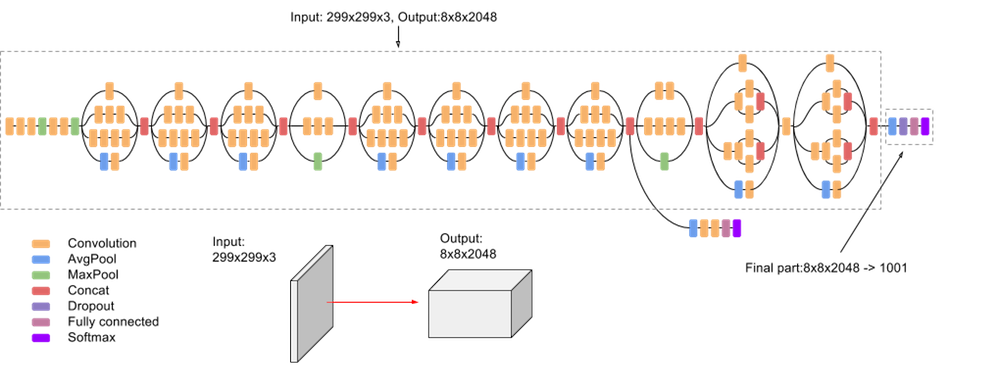

The inception model is characterized by its combination of symmetric and asymmetric components, incorporating convolutions, average pooling, max pooling, concatenations, dropouts, and fully connected layers. Batch normalization is extensively used throughout the model and applied to activation inputs. One distinctive feature of Inception is its inception module, which employs filters of different sizes simultaneously, enabling the model to capture features at various scales. This architecture allows for a more effective extraction of intricate patterns and contributes to the model's robust performance across different tasks. The Softmax function is employed to calculate the loss, facilitating efficient training and prediction.

In [ ]:
torch.manual_seed(0) #Fix values

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 191MB/s] 


In [ ]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
total_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("{} parameters trainables".format(total_params))

27161264 parameters trainables


Here, we are dealing with over 27 million parameters to train, which is why we need to utilize a GPU for faster computation.

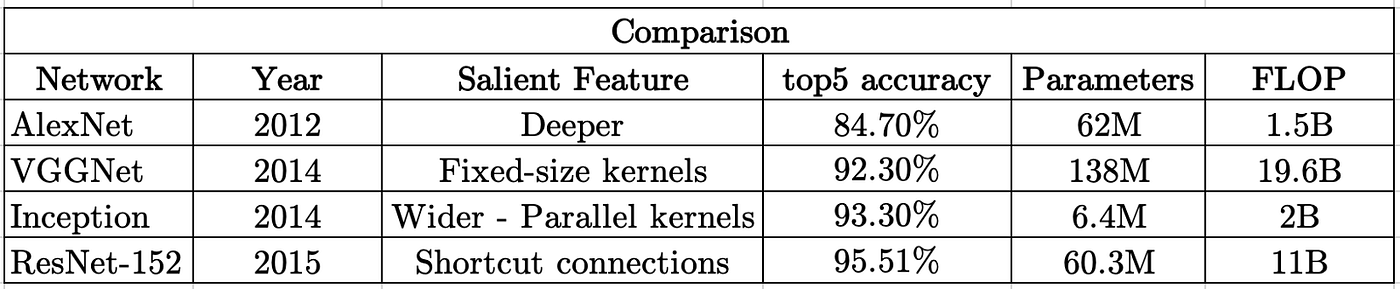

In [ ]:
device = (
    'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(f"We are using {device} device for this project")

We are using cuda device for this project


In PyTorch's Inception model, the `aux_logits` parameter controls whether to include an auxiliary classifier. This auxiliary classifier is an additional branch in the network that helps with the training of the main classifier. It is often used during training to mitigate the vanishing gradient problem.

By setting `model.aux_logits` to `False`, you are indicating that you do not want to include this auxiliary classifier during the transfer learning process. This is a common practice when fine-tuning a pre-trained model for a specific task.

Here's an explanation of the parameter:

- `aux_logits` (bool, optional): If True, adds an auxiliary classifier branch. Default: True.

By setting it to `False`, you are essentially removing the auxiliary classifier branch, simplifying the model for your specific task. This can be beneficial when you have limited data and want to focus on fine-tuning the main classifier.

In [ ]:
model.aux_logits = False

In [ ]:
model.fc # The dense neural network output

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
# Change the default dense neural network
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.Linear(1024, 512),
    nn.Linear(512, 256),
    nn.Linear(256, len(labels))
)

print('New dnn')
print(model.fc)

New dnn
Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=512, bias=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Linear(in_features=256, out_features=24, bias=True)
)


In [ ]:
#parameters
lr = 0.001
epochs = 30
seed = 123

# Define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9)

In SGD, when updating the model parameters at each iteration, **momentum** is a technique that accelerates the convergence of the optimization algorithm by taking into account previous updates. This is done by adding a fraction of the previous update vector to the current parameter update.

**Momentum** acts as a form of inertia, allowing the optimizer to maintain a certain direction and velocity in the parameter updates, which can help escape local minima and converge more quickly towards a global minimum.

In [ ]:
def trainer(dataloader, validloader, model, criterion, optimizer, epochs=5):
    """
    This function allows you to train a model using training data sets (dataloader) while evaluating its performance on validation data.
    Using tqdm (taqadum) provides a visual progress bar to track training and assessment progress.
    A separate progress bar is used for each training epoch, showing progress across training batches, as well as a separate progress bar for evaluation on validation data.
    ---
    We return two lists, loss_cache and valid_cache, which respectively contain the average training losses for each epoch and the evaluation results on the validation data,
    such as average loss and accuracy.
    """
    size = len(dataloader)
    model = model.to(device)
    model.train()
    loss_cache = []
    valid_cache = []
    acc = []
    loss_test = []
    training_time = []

    for i in tqdm(range(epochs+1), desc="Epochs", unit="epoch"):
      total_loss = 0
      start_time = time.time()

      for batch, (X, y) in enumerate(dataloader):
      # compute prediction and loss
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = criterion(preds, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

      # Time calcul
      end_time = time.time()
      train_time = end_time - start_time
      training_time.append(train_time)
      print("Time for training epoch {} : {:.2f} seconds".format(i+1, train_time))

      # Calculate loss
      avg_loss = total_loss / size
      loss_cache.append(avg_loss)
      print(f"\nEpoch {i + 1}/{epochs+1} - Avg Training Loss: {avg_loss:.6f}")

      # Evaluation on validation set
      model.eval()
      total_correct = 0
      total_test_loss = 0

      with torch.no_grad():
        for X_val, y_val in validloader:
          X_val = X_val.to(device)
          y_val = y_val.to(device)
          preds_val = model(X_val)
          total_test_loss += criterion(preds_val, y_val).item()
          total_correct += (preds_val.argmax(1) == y_val).type(torch.float).sum().item()


      avg_test_loss = total_test_loss / len(validloader)
      accuracy = total_correct / len(validloader.dataset)
      acc.append(accuracy)
      loss_test.append(avg_test_loss)
      valid_cache.append({"test_loss": loss_test, "accuracy": acc})

      # Print loss and accuracy for the valid loader
      print(f"Validation - Avg Loss: {avg_test_loss:.6f} | Accuracy: {accuracy * 100:.2f}%\n")

    # Time for the training
    total_time = sum(training_time)
    print("Total training time for {} epochs: {:.2f} seconds".format(epochs, total_time))

    return loss_cache, valid_cache

In [ ]:
loss_cache, valid_cache = trainer(train_dataloader, test_dataloader, model, criterion, optimizer, epochs)

Epochs:   0%|          | 0/31 [00:00<?, ?epoch/s]

Time for training epoch 1 : 68.46 seconds

Epoch 1/31 - Avg Training Loss: 3.173052


Epochs:   3%|▎         | 1/31 [01:41<50:58, 101.94s/epoch]

Validation - Avg Loss: 3.169899 | Accuracy: 2.97%

Time for training epoch 2 : 62.59 seconds

Epoch 2/31 - Avg Training Loss: 3.133679


Epochs:   6%|▋         | 2/31 [03:00<42:30, 87.95s/epoch] 

Validation - Avg Loss: 3.083742 | Accuracy: 21.53%

Time for training epoch 3 : 62.63 seconds

Epoch 3/31 - Avg Training Loss: 2.145491


Epochs:  10%|▉         | 3/31 [04:18<38:56, 83.45s/epoch]

Validation - Avg Loss: 1.238290 | Accuracy: 60.40%

Time for training epoch 4 : 62.74 seconds

Epoch 4/31 - Avg Training Loss: 0.853191


Epochs:  13%|█▎        | 4/31 [05:36<36:43, 81.60s/epoch]

Validation - Avg Loss: 0.578998 | Accuracy: 80.69%

Time for training epoch 5 : 63.51 seconds

Epoch 5/31 - Avg Training Loss: 0.553316


Epochs:  16%|█▌        | 5/31 [06:56<35:01, 80.85s/epoch]

Validation - Avg Loss: 0.444645 | Accuracy: 83.66%

Time for training epoch 6 : 63.56 seconds

Epoch 6/31 - Avg Training Loss: 0.278156


Epochs:  19%|█▉        | 6/31 [08:15<33:28, 80.32s/epoch]

Validation - Avg Loss: 0.310429 | Accuracy: 89.11%

Time for training epoch 7 : 66.36 seconds

Epoch 7/31 - Avg Training Loss: 0.245050


Epochs:  23%|██▎       | 7/31 [09:38<32:23, 81.00s/epoch]

Validation - Avg Loss: 0.210996 | Accuracy: 93.56%

Time for training epoch 8 : 62.65 seconds

Epoch 8/31 - Avg Training Loss: 0.145503


Epochs:  26%|██▌       | 8/31 [10:56<30:42, 80.11s/epoch]

Validation - Avg Loss: 0.221961 | Accuracy: 92.08%

Time for training epoch 9 : 61.82 seconds

Epoch 9/31 - Avg Training Loss: 0.186390


Epochs:  29%|██▉       | 9/31 [12:13<29:03, 79.26s/epoch]

Validation - Avg Loss: 0.289061 | Accuracy: 93.56%

Time for training epoch 10 : 62.35 seconds

Epoch 10/31 - Avg Training Loss: 0.091791


Epochs:  32%|███▏      | 10/31 [13:31<27:34, 78.78s/epoch]

Validation - Avg Loss: 0.068230 | Accuracy: 97.52%

Time for training epoch 11 : 61.80 seconds

Epoch 11/31 - Avg Training Loss: 0.091234


Epochs:  35%|███▌      | 11/31 [14:49<26:08, 78.45s/epoch]

Validation - Avg Loss: 0.078483 | Accuracy: 96.53%

Time for training epoch 12 : 63.54 seconds

Epoch 12/31 - Avg Training Loss: 0.091619


Epochs:  39%|███▊      | 12/31 [16:08<24:55, 78.72s/epoch]

Validation - Avg Loss: 0.521460 | Accuracy: 88.37%

Time for training epoch 13 : 62.88 seconds

Epoch 13/31 - Avg Training Loss: 0.077377


Epochs:  42%|████▏     | 13/31 [17:27<23:37, 78.77s/epoch]

Validation - Avg Loss: 0.083777 | Accuracy: 95.30%

Time for training epoch 14 : 63.05 seconds

Epoch 14/31 - Avg Training Loss: 0.058456


Epochs:  45%|████▌     | 14/31 [18:46<22:19, 78.77s/epoch]

Validation - Avg Loss: 0.031141 | Accuracy: 99.01%

Time for training epoch 15 : 63.56 seconds

Epoch 15/31 - Avg Training Loss: 0.091694


Epochs:  48%|████▊     | 15/31 [20:05<21:02, 78.90s/epoch]

Validation - Avg Loss: 0.016997 | Accuracy: 99.50%

Time for training epoch 16 : 63.79 seconds

Epoch 16/31 - Avg Training Loss: 0.037693


Epochs:  52%|█████▏    | 16/31 [21:25<19:47, 79.14s/epoch]

Validation - Avg Loss: 0.053258 | Accuracy: 98.51%

Time for training epoch 17 : 63.25 seconds

Epoch 17/31 - Avg Training Loss: 0.014938


Epochs:  55%|█████▍    | 17/31 [22:43<18:26, 79.02s/epoch]

Validation - Avg Loss: 0.058618 | Accuracy: 98.76%

Time for training epoch 18 : 62.29 seconds

Epoch 18/31 - Avg Training Loss: 0.069692


Epochs:  58%|█████▊    | 18/31 [24:01<17:02, 78.68s/epoch]

Validation - Avg Loss: 0.004191 | Accuracy: 100.00%

Time for training epoch 19 : 62.31 seconds

Epoch 19/31 - Avg Training Loss: 0.015139


Epochs:  61%|██████▏   | 19/31 [25:19<15:42, 78.51s/epoch]

Validation - Avg Loss: 0.045485 | Accuracy: 98.27%

Time for training epoch 20 : 62.81 seconds

Epoch 20/31 - Avg Training Loss: 0.053650


Epochs:  65%|██████▍   | 20/31 [26:38<14:23, 78.48s/epoch]

Validation - Avg Loss: 0.038560 | Accuracy: 99.01%

Time for training epoch 21 : 61.59 seconds

Epoch 21/31 - Avg Training Loss: 0.046720


Epochs:  68%|██████▊   | 21/31 [27:55<13:00, 78.09s/epoch]

Validation - Avg Loss: 0.022654 | Accuracy: 99.01%

Time for training epoch 22 : 61.92 seconds

Epoch 22/31 - Avg Training Loss: 0.035482


Epochs:  71%|███████   | 22/31 [29:12<11:40, 77.81s/epoch]

Validation - Avg Loss: 0.017355 | Accuracy: 99.50%

Time for training epoch 23 : 60.97 seconds

Epoch 23/31 - Avg Training Loss: 0.007859


Epochs:  74%|███████▍  | 23/31 [30:28<10:18, 77.34s/epoch]

Validation - Avg Loss: 0.017763 | Accuracy: 99.50%

Time for training epoch 24 : 60.84 seconds

Epoch 24/31 - Avg Training Loss: 0.004604


Epochs:  77%|███████▋  | 24/31 [31:44<08:58, 76.89s/epoch]

Validation - Avg Loss: 0.003758 | Accuracy: 99.75%

Time for training epoch 25 : 61.96 seconds

Epoch 25/31 - Avg Training Loss: 0.000462


Epochs:  81%|████████  | 25/31 [33:01<07:42, 77.02s/epoch]

Validation - Avg Loss: 0.000840 | Accuracy: 100.00%

Time for training epoch 26 : 60.78 seconds

Epoch 26/31 - Avg Training Loss: 0.012257


Epochs:  84%|████████▍ | 26/31 [34:18<06:23, 76.75s/epoch]

Validation - Avg Loss: 0.007954 | Accuracy: 99.75%

Time for training epoch 27 : 61.05 seconds

Epoch 27/31 - Avg Training Loss: 0.036199


Epochs:  87%|████████▋ | 27/31 [35:34<05:06, 76.64s/epoch]

Validation - Avg Loss: 0.003168 | Accuracy: 100.00%

Time for training epoch 28 : 61.35 seconds

Epoch 28/31 - Avg Training Loss: 0.003838


Epochs:  90%|█████████ | 28/31 [36:51<03:50, 76.68s/epoch]

Validation - Avg Loss: 0.002336 | Accuracy: 100.00%

Time for training epoch 29 : 62.25 seconds

Epoch 29/31 - Avg Training Loss: 0.001499


Epochs:  94%|█████████▎| 29/31 [38:09<02:34, 77.08s/epoch]

Validation - Avg Loss: 0.000475 | Accuracy: 100.00%

Time for training epoch 30 : 62.14 seconds

Epoch 30/31 - Avg Training Loss: 0.000259


Epochs:  97%|█████████▋| 30/31 [39:27<01:17, 77.31s/epoch]

Validation - Avg Loss: 0.000383 | Accuracy: 100.00%

Time for training epoch 31 : 62.43 seconds

Epoch 31/31 - Avg Training Loss: 0.000129


Epochs: 100%|██████████| 31/31 [40:45<00:00, 78.88s/epoch]

Validation - Avg Loss: 0.000321 | Accuracy: 100.00%

Total training time for 30 epochs: 1943.24 seconds


In [ ]:
print("loss train = {:.2f} and loss test = {:.2f}".format(loss_cache[-1], valid_cache[-1]['test_loss'][-1]))
print("Accuracy on the test set = {}".format(valid_cache[-1]['accuracy'][-1]))

loss train = 0.00 and loss test = 0.00
Accuracy on the test set = 1.0


In [ ]:
def save_model(model, save_path):
  """
  Save the model's state_dict to the specified directory.


  Args:
  - model: The PyTorch model.
  - save_path (str): The directory path for saving the model.

  Returns:
  None
  """
  # Check if the directory exists, create it if not
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  # Save the model's state_dict
  model_path = os.path.join(save_path, 'model.pth')
  torch.save(model.state_dict(), model_path)

In [ ]:
save_model(model, 'save')

Next step, let's evaluate how our model identifies signs and understand the underlying factors it relies on in reality.

Our goal is to delve into the interpretability of the model's predictions. We want to explore what features or patterns in the input data are crucial for the model when making predictions. This process involves visualizing and analyzing the activations of different layers in the neural network, observing what parts of an input image contribute the most to the final decision.

By gaining insights into the model's decision-making process, we can enhance our understanding of its strengths, weaknesses, and areas for improvement. This interpretability analysis is essential for building trust in the model's predictions and refining its performance on specific tasks.

## Evaluation

In [ ]:
# Set theme
sns.set(style='darkgrid')

In [ ]:
def evaluation(loss_cache, valid_cache):
  """
  Parameters
  ----------
  loss_cache : LIST
    The list of the loss train.
  valid_cache : DICTIONARY
    The dictionnary(test_loss - accuracy) of the validation set with training.

  Returns
  -------
  None.

  """

  #extract values here
  loss_test = valid_cache[0]['test_loss']
  acc_test = valid_cache[1]['accuracy']


  #Figure
  #Accuracy visualisation
  fig, ax = plt.subplots(2, 1, figsize=(8, 5))
  ax[0].set_title("Inception V3 Accuracy")
  ax[0].plot(acc_test, label="Accuracy of the training", marker='o', linewidth=2, color = 'orange')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  fig.tight_layout()
  sns.despine(ax=ax[0], right=True, top=True)

  #Loss visualisation
  ax[1].set_title("Inception V3 Loss")
  ax[1].plot(loss_test, label="Loss of the training", marker='o', linewidth=2)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

  fig.tight_layout()
  sns.despine(ax=ax[1], right=True, top=True)

  fig.show()
  fig.savefig('save/Comparaison inception.png')

In [ ]:
# Perform classification report
y_test = torch.tensor([])
y_hat = torch.tensor([])

with torch.no_grad():
  model.eval()
  for X_batch, y_batch in test_dataloader:
    X_batch = X_batch.to(device)
    preds = model(X_batch)

    _, y_pred = torch.max(preds.data, 1)
    y_pred = y_pred.cpu()

    # Create y_test and y_hat
    y_test = torch.cat((y_test, y_batch))
    y_hat = torch.cat((y_hat, y_pred))

In [ ]:
# Use the dict_labels dictionary to map predicted and actual indices to the true classes
y_test_labels = [list(dict_labels.keys())[list(dict_labels.values()).index(int(val))] for val in y_test]
y_hat_labels = [list(dict_labels.keys())[list(dict_labels.values()).index(int(val))] for val in y_hat]

In [ ]:
print(classification_report(y_test_labels, y_hat_labels))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        15
           B       1.00      1.00      1.00        17
           C       1.00      1.00      1.00        16
           D       1.00      1.00      1.00        16
           E       1.00      1.00      1.00        17
           F       1.00      1.00      1.00        18
           G       1.00      1.00      1.00        18
           H       1.00      1.00      1.00        15
           I       1.00      1.00      1.00        17
           K       1.00      1.00      1.00        17
           L       1.00      1.00      1.00        18
           M       1.00      1.00      1.00        17
           N       1.00      1.00      1.00        16
           O       1.00      1.00      1.00        17
           P       1.00      1.00      1.00        17
           Q       1.00      1.00      1.00        18
           R       1.00      1.00      1.00        17
           S       1.00    

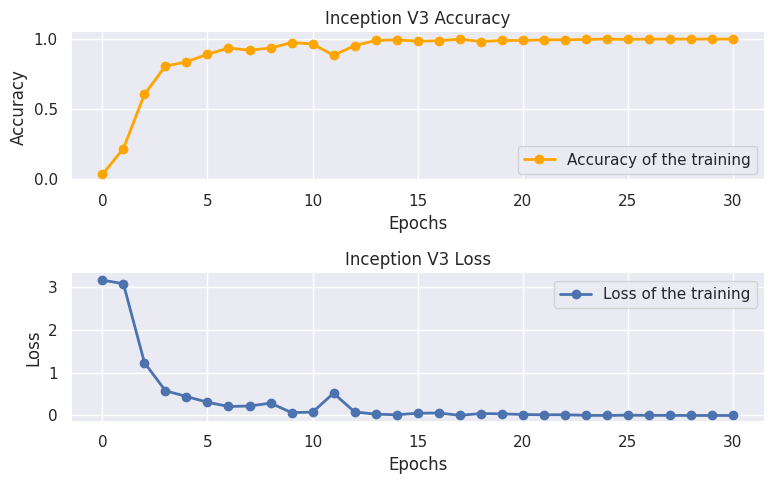

In [ ]:
evaluation(loss_cache, valid_cache)

We observe from this classification report that the model has achieved an excellent overall performance in a multi-class classification task.

This indicates that the model excels in correctly identifying instances from these classes, both in terms of sensitivity (recall) and positive predictive value (precision). The high F1-score suggests a well-balanced trade-off between precision and recall, showcasing the model's effectiveness in handling various classes in the classification task.

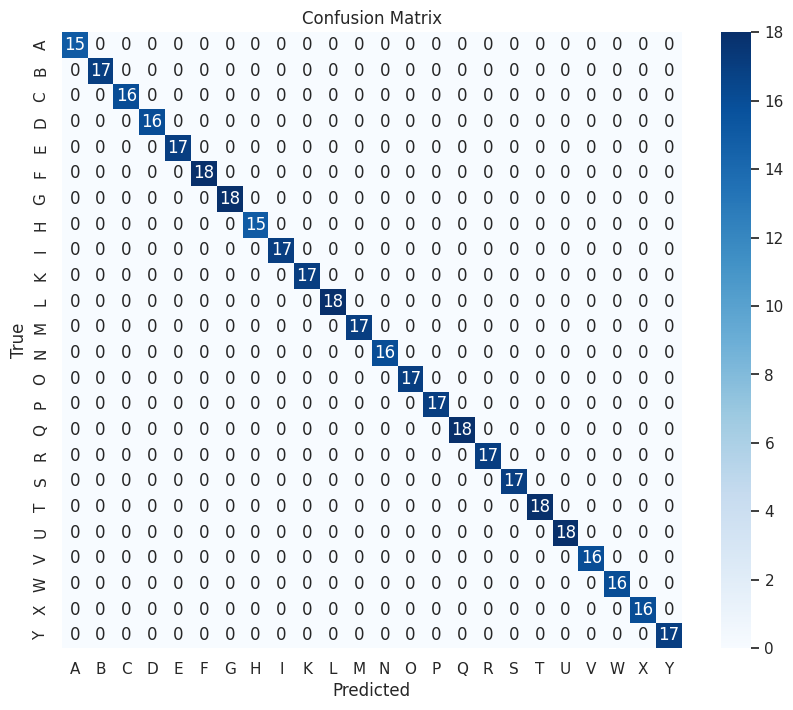

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_hat_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('save/confusion_matrix.png')
plt.show()


By using the confusion matrix, we can visualize how the model makes errors. Specifically, for the first scenario involving class A, it is evident that the model often misclassifies A as E. This suggests that the model identifies similarities between these two classes, leading to misclassifications.

## Deployment


We've decided to play a game together: We want to test the model's performance in real-life situations, so we took photos of ourselves making signs.

Jessica, Maheni, Habiba, Arnold, and Darryl were the models, and Fozame was the photographer.

After the photoshoot, we'll now see if the model can accurately predict the represented signs.

In [ ]:
labels_y = ['V','Y', 'M', 'R', 'H']

In [ ]:
# path of the images
jessica = '/content/drive/MyDrive/Machine Learning project Aivancity/Datasets/classification images/sign classification/test/V/jessica.jpeg'
maheni = '/content/drive/MyDrive/Machine Learning project Aivancity/Datasets/classification images/sign classification/test/Y/maheni.jpeg'
habiba = '/content/drive/MyDrive/Machine Learning project Aivancity/Datasets/classification images/sign classification/test/E/habiba.jpeg'
arnold = '/content/drive/MyDrive/Machine Learning project Aivancity/Datasets/classification images/sign classification/test/R/arnold.jpeg'
darryl = '/content/drive/MyDrive/Machine Learning project Aivancity/Datasets/classification images/sign classification/test/U/darryl.jpeg'

In [ ]:
# Config list and name
members_without_fozame = [jessica, maheni, habiba, arnold, darryl]
name_without_fozame = ['Jessica', 'Maheni', 'Habiba', 'Arnold', 'Darryl']

In [ ]:
def predict(model, img, predict_prob=False):
  """
  This function allows you to predict the sign by taking the image as input.

  Args:
  - model (torch Inception V3): Inception V3 model built with PyTorch.
  - img (numpy.ndarray): Numpy array of the image we want to predict.

  Returns:
  - (list or torch.Tensor): If `predict_prob` is False, returns a list of predicted class.
                               If `predict_prob` is True, returns a tensor of predicted probabilities.
  """
  img = cv2.resize(img, (299,299))
  img_tensor = normalize(torch.tensor(img))
  img_tensor = img_tensor.permute(2, 0, 1)
  img_tensor = transform(img_tensor).unsqueeze(0)  # Add batch dimension

  # Load the pre-trained Inception model
  model = model.to(device)
  img_tensor = img_tensor.to(device)
  model.eval()

  # Perform inference on the image
  with torch.no_grad():
    output = model(img_tensor)

  # Get the predicted label
  probabilities = F.softmax(output[0], dim=0)
  predicted_class_index = torch.argmax(probabilities).item()
  predicted_label = list(dict_labels.keys())[predicted_class_index]

  if predict_prob == True:
    return probabilities
  else:
    return predicted_label

In [ ]:
def plot_prediction(model, values, y, name):
  """
  This function plots the original images along with their predicted labels.

  Args:
  - model (torch.nn.Module): The trained model used for prediction.
  - values (list): List of image paths.
  - y (list): List of true labels corresponding to the images.
  - name (list): List of names corresponding to the images.

  Returns:
  None
  """

  # Plot original images and predictions
  fig, axs = plt.subplots(len(values), 2, figsize=(10, 15))
  fig.suptitle('Prediction of the inception model on the members')

  for i in range(len(values)):
    img = cv2.imread(values[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y_hat = predict(model, img)

    # Check if prediction is correct
    if y_hat == y[i]:
      label_color = 'green'  # Correct prediction, label color is black
    else:
      label_color = 'red'    # Incorrect prediction, label color is red

    # Plot original image
    axs[i, 0].imshow(img)
    axs[i, 0].set_title('{} Image = {}'.format(name[i], y[i]), color = 'green')
    axs[i, 0].axis('off')

    # Plot predicted label
    axs[i, 1].imshow(img)
    axs[i, 1].set_title('Predicted = {}'.format(y_hat), color = label_color)
    axs[i, 1].axis('off')

    fig.tight_layout()
    fig.show()
    fig.savefig('save/game.png')

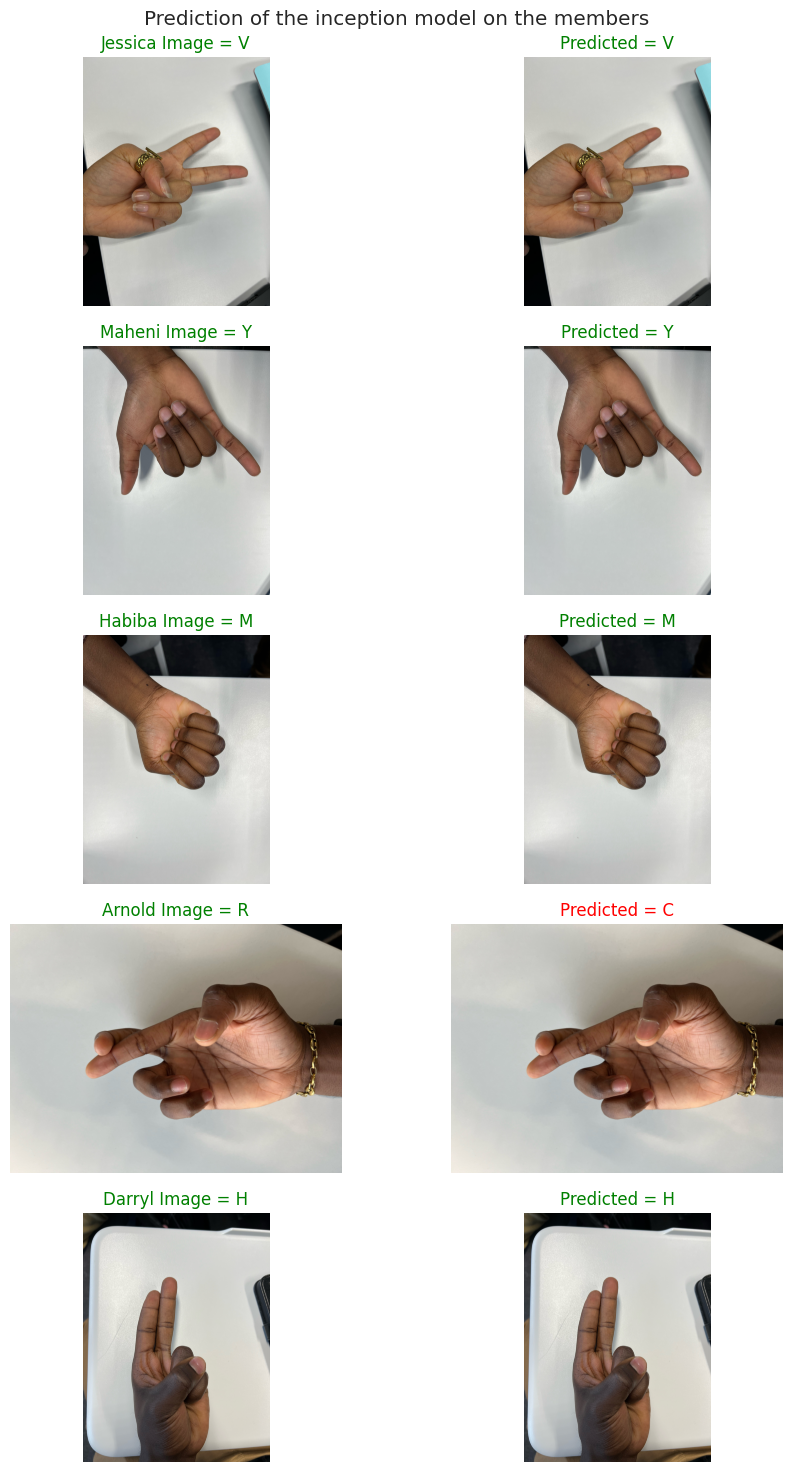

In [ ]:
plot_prediction(model, members_without_fozame, labels_y, name_without_fozame)

Unfortunately, Arnold lost :(
  
But we still understand why the model confused his sign.

The sign for "C" in the training data is quite similar to "R". Additionally, "U" and "H" are visually similar (Darryl).

However, the model was able to correctly predict 4 out of 5 signs. It generalizes perfectly.